In [91]:
#Librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer, LSTM
from tensorflow.keras.losses import MeanSquaredError
from sklearn.metrics import root_mean_squared_error


# Carga y Preparación de data

In [92]:
consumo = pd.read_excel("CONSUMO-2024-06.xlsx", skiprows = 6)
importacion = pd.read_excel("IMPORTACION-VOLUMEN-2024-06.xlsx", skiprows = 6)
precios2024 = pd.read_excel("Precios-Promedio-Nacionales-Diarios-2024-2.xlsx", sheet_name = "2024", skiprows = 9, header = None, 
                        names = ["Fecha", "Tipo de Cambio", "Superior", "Regular", "Diesel", "Bunker", "Glp Cilindro 25Lbs (GTQ/CIL 25 LB)", 
                                 "Glp Cilindro 25Lbs. (GTQ/LB)"])
precios2023 = pd.read_excel("Precios-Promedio-Nacionales-Diarios-2024-2.xlsx", sheet_name = "2023", skiprows = 9, header = None,
                            names = ["Fecha", "Tipo de Cambio", "Superior", "Regular", "Diesel", "Bunker", "Glp Cilindro 25Lbs (GTQ/CIL 25 LB)", 
                                 "Glp Cilindro 25Lbs. (GTQ/LB)"])
precios2022 = pd.read_excel("Precios-Promedio-Nacionales-Diarios-2024-2.xlsx", sheet_name = "2022", skiprows = 8, header = None,
                            names = ["Fecha", "Tipo de Cambio", "Superior", "Regular", "Diesel", "Bunker", "Glp Cilindro 25Lbs (GTQ/CIL 25 LB)", 
                                 "Glp Cilindro 25Lbs. (GTQ/LB)"])
precios2021 = pd.read_excel("Precios-Promedio-Nacionales-Diarios-2024-2.xlsx", sheet_name = "2021", skiprows = 8, header = None,
                            names = ["Fecha", "Tipo de Cambio", "Superior", "Regular", "Diesel", "Bunker", "Glp Cilindro 25Lbs (GTQ/CIL 25 LB)", 
                                 "Glp Cilindro 25Lbs. (GTQ/LB)"])

In [93]:
precios2024.drop(precios2024.tail(9).index, inplace = True)
precios2023.drop(precios2023.tail(2).index, inplace = True)
precios2022.drop(precios2022.tail(2).index, inplace = True)
precios2021.drop(precios2021.tail(2).index, inplace = True)

In [94]:
precios = pd.concat([precios2021, precios2022, precios2023, precios2024], ignore_index = True)

In [95]:
#Se suman los consumos de Diesel, ya que de 2000 a 2018 se consumía alto en azufre y a partir de enero 2018 se consumía bajo en azufre
consumo["Diesel"] = consumo["Diesel bajo azufre"]+consumo["Diesel alto azufre"]
importacion["Diesel"] = importacion["Diesel bajo azufre"]+importacion["Diesel alto azufre"]

In [96]:
consumo = consumo[["Fecha", "Diesel", "Gas licuado de petróleo", "Gasolina regular", "Gasolina superior"]].copy()
importacion = importacion[["Fecha", "Diesel", "Gas licuado de petróleo", "Gasolina regular", "Gasolina superior"]].copy()
precios = precios[["Fecha", "Diesel", "Glp Cilindro 25Lbs (GTQ/CIL 25 LB)", "Regular", "Superior"]].copy()

In [97]:
consumo.drop(consumo.tail(3).index, inplace = True)
importacion.drop(importacion.tail(3).index, inplace = True)

In [98]:
consumo["Fecha"] = pd.to_datetime(consumo["Fecha"])
importacion["Fecha"] = pd.to_datetime(importacion["Fecha"])
precios["Fecha"] = pd.to_datetime(precios["Fecha"])

# Modelos LSTM

In [99]:
tf.random.set_seed(1122)

## Consumo Gasolina Regular

In [100]:
regular = consumo[["Fecha", "Gasolina regular"]].copy()
regular.set_index("Fecha", inplace = True)
regular.head()


,Gasolina regular
Fecha,
2000-01-01,202645.20
2000-02-01,205530.96
2000-03-01,229499.56
2000-04-01,210680.40
2000-05-01,208164.34


In [101]:
print("Prueba de Dickey-Fuller para la serie de tiempo de consumo de gasolina regular")
regularTest = adfuller(regular, autolag = "AIC")
salidaDf = pd.Series(regularTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in regularTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Prueba de Dickey-Fuller para la serie de tiempo de consumo de gasolina regular
Estadístico de prueba          2.430669
p-value                        0.999024
# de retardos usados          14.000000
# de observaciones usadas    279.000000
Critical Value (1%)           -3.454008
Critical Value (5%)           -2.871956
Critical Value (10%)          -2.572320
dtype: float64


El valor-p de la prueba ADF confirma que no es una serie de tiempo estacionaria en media. Por lo tanto, es necesario diferenciarla.

In [102]:
print("Prueba de Dickey-Fuller para una diferenciación de la serie de tiempo de importación de gasolina regular")
regular_diff = regular.diff()
regular_diff.fillna(0,inplace = True)
regularTest = adfuller(regular_diff, autolag = "AIC")
salidaDf = pd.Series(regularTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in regularTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Prueba de Dickey-Fuller para una diferenciación de la serie de tiempo de importación de gasolina regular
Estadístico de prueba         -4.316925
p-value                        0.000415
# de retardos usados          16.000000
# de observaciones usadas    277.000000
Critical Value (1%)           -3.454180
Critical Value (5%)           -2.872031
Critical Value (10%)          -2.572360
dtype: float64


El valor-p confirma que con una diferenciación es suficiente para que la serie de tiempo sea estacionaria en media.

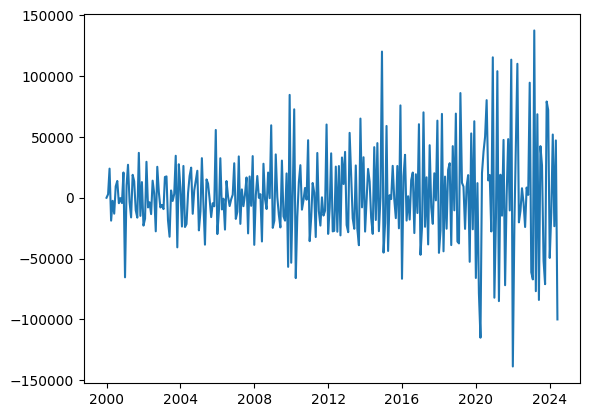

In [103]:
plt.plot(regular_diff)

In [104]:
scaler = StandardScaler()
regular_diff_scaled = scaler.fit_transform(regular_diff)

### Separación entre set de entrenamiento y testeo (igual al laboratorio 2)

In [105]:
num_separacion = consumo.index[consumo["Fecha"]==pd.to_datetime("2021-12")][0]
num_val = int(len(regular_diff_scaled)*0.1)
train = regular_diff_scaled[:num_separacion-num_val]
validation = regular_diff_scaled[num_separacion-num_val:num_separacion]
test = regular_diff_scaled[num_separacion:]
#train = regular_diff[:num_separacion]
#test = regular_diff[num_separacion:]

In [106]:
def df_a_X_y(df,retrasos = 1):
    if type(df) is pd.DataFrame:
        df_as_np = df.to_numpy()
    else:
        df_as_np = df
    X = []
    y = []
    for i in range(len(df_as_np)-retrasos):
        row = [a for a in df_as_np[i:(i+retrasos)]]
        X.append(row)
        label = df_as_np[i+retrasos][0]
        y.append(label)
        
    return np.array(X), np.array(y)


retrasos = 1
x_train,y_train = df_a_X_y(train, retrasos)
x_val,y_val = df_a_X_y(validation, retrasos)
x_test,y_test = df_a_X_y(test, retrasos)

### Creación primer modelo

In [108]:
modelo1 = Sequential()

modelo1.add(InputLayer((retrasos, 1)))
modelo1.add(LSTM(64))
modelo1.add(Dense(8, 'relu'))
modelo1.add(Dense(1, 'linear'))
modelo1.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_7 (LSTM)                   │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,425 (68.07 KB)

 Trainable params: 17,425 (68.07 KB)

 Non-trainable params: 0 (0.00 B)

In [109]:
modelo1.compile(loss=MeanSquaredError(),optimizer="rmsprop")

In [110]:
epocas = 50
history= modelo1.fit(
    x = x_train,
    y = y_train,
    epochs = epocas,
    shuffle = False,
    validation_data = (x_val, y_val)
)

Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 0.4249 - val_loss: 2.1526
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4057 - val_loss: 2.1129
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3959 - val_loss: 2.0819
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3878 - val_loss: 2.0545
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3807 - val_loss: 2.0307
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3744 - val_loss: 2.0099
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3689 - val_loss: 1.9924
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3643 - val_loss: 1.9778
Epoch 9/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3607 - val_loss: 1.9660
Epoch 10/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3578 - val_loss: 1.9568
Epoch 11/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3554 - val_loss: 1.9499
Epoch 12/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3538 - val_loss: 1.9448
Epoch 13/50


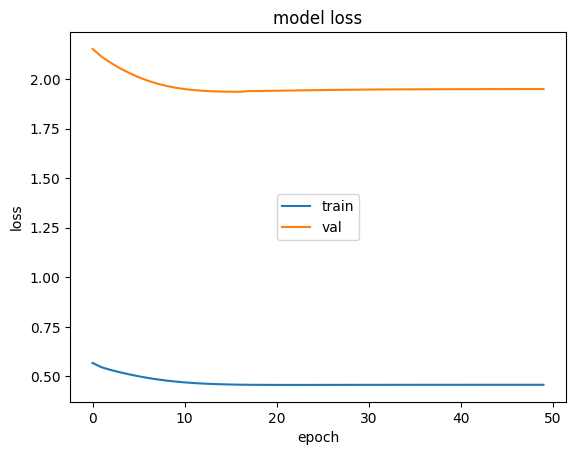

In [111]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='center')

In [112]:
print("Pérdida en Entrenamiento")
modelo1.evaluate(
    x = x_train,
    y = y_train
)
print("Pérdida en Validación")
modelo1.evaluate(
    x = x_val,
    y = y_val
)
print("Pérdida en Prueba")
modelo1.evaluate(
    x = x_test,
    y = y_test
)

Pérdida en Entrenamiento
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3596 
Pérdida en Validación
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.9500
Pérdida en Prueba
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 2.2864


2.286351442337036

In [113]:
def prediccion_fun(data,modelo, batch_size,scaler,dif=False,dif_cant=1, Series = None , n=1, retrasos = 1):
    prediccion = [0]* (len(data))
    i=0
    for X in data:
        yhat = modelo.predict(X, batch_size=batch_size,verbose=0)
        # invert scaling
        yhat = scaler.inverse_transform(yhat)
        if dif:
             # invert differencing
            yhat  = yhat + Series[(n+retrasos-1+dif_cant*i)]
        # store
        prediccion[i]=yhat[0][0]
        i = i+1
    return prediccion

In [114]:
prediccion_train = prediccion_fun(x_train,modelo1, 1,scaler,dif=True,dif_cant=1, Series = regular.values, n=0, retrasos = retrasos)
prediccion_val = prediccion_fun(x_val,modelo1, 1,scaler,dif=True,dif_cant=1, Series = regular.values , n=num_separacion-num_val, retrasos = retrasos)
prediccion_test = prediccion_fun(x_test,modelo1, 1,scaler,dif=True,dif_cant=1, Series = regular.values , n=num_separacion, retrasos = retrasos)

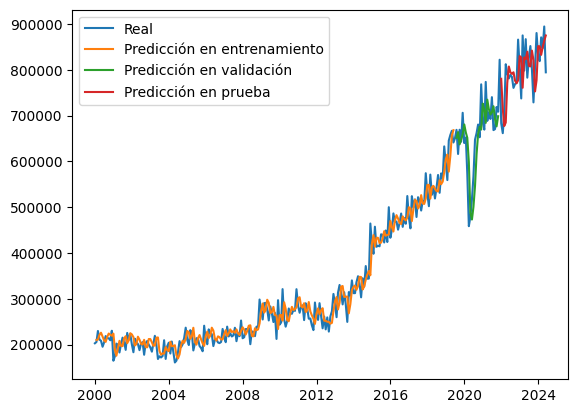

In [115]:
df_train = pd.DataFrame(prediccion_train, columns = ["Predicción en entrenamiento"], index = regular[1:num_separacion-num_val].index)
df_val = pd.DataFrame(prediccion_val, columns = ["Predicción en validación"], index = regular[num_separacion-num_val+1:num_separacion].index)
df_test = pd.DataFrame(prediccion_test, columns = ["Predicción en prueba"], index = regular[num_separacion+1:].index)

plt.plot(regular, label = "Real")
plt.plot(df_train, label = "Predicción en entrenamiento")
plt.plot(df_val, label = "Predicción en validación")
plt.plot(df_test, label = "Predicción en prueba")
plt.legend()
plt.show()

Los errores de los modelos generados en el laboratorio 2 son los siguientes:

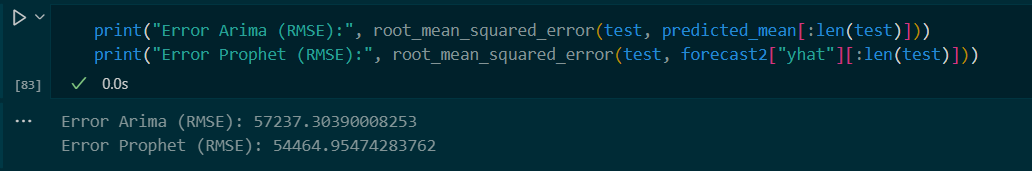

In [209]:
from IPython.display import Image
Image("ErroresRegular.png")

Error del primer LSTM:

In [116]:
print("RMSE modelo1 (sobre el conjunto de prueba):", root_mean_squared_error(regular[num_separacion+retrasos:], df_test))

RMSE modelo1 (sobre el conjunto de prueba): 58824.40512385161


### Creación segundo modelo

In [133]:
retrasos = 2
x_train,y_train = df_a_X_y(train, retrasos)
x_val,y_val = df_a_X_y(validation, retrasos)
x_test,y_test = df_a_X_y(test, retrasos)

modelo2 = Sequential()

modelo2.add(InputLayer((retrasos, 1)))
modelo2.add(LSTM(64))
modelo2.add(Dense(16, 'relu'))
modelo2.add(Dense(8, 'relu'))
modelo2.add(Dense(1, 'linear'))
modelo2.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_10 (LSTM)                  │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,081 (70.63 KB)

 Trainable params: 18,081 (70.63 KB)

 Non-trainable params: 0 (0.00 B)

In [134]:
modelo2.compile(loss=MeanSquaredError(),optimizer="rmsprop")

In [135]:
epocas = 100
history= modelo2.fit(
    x = x_train,
    y = y_train,
    epochs = epocas,
    shuffle = False,
    validation_data = (x_val, y_val)
)

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.4317 - val_loss: 2.2929
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4159 - val_loss: 2.2759
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4052 - val_loss: 2.2594
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3944 - val_loss: 2.2423
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3830 - val_loss: 2.2255
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3715 - val_loss: 2.2077
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3599 - val_loss: 2.1910
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3488 - val_loss: 2.1744
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3383 - val_loss: 2.1614
Epoch 10/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3289 - val_loss: 2.1501
Epoch 11/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3205 - val_loss: 2.1439
Epoch 12/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3136 - val_loss: 2.1375


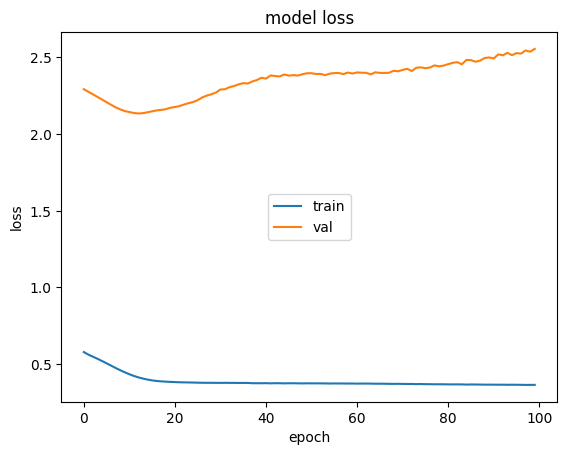

In [136]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='center')

In [137]:
print("Pérdida en Entrenamiento")
modelo2.evaluate(
    x = x_train,
    y = y_train
)
print("Pérdida en Validación")
modelo2.evaluate(
    x = x_val,
    y = y_val
)
print("Pérdida en Prueba")
modelo2.evaluate(
    x = x_test,
    y = y_test
)

Pérdida en Entrenamiento
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3071 
Pérdida en Validación
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 2.5554
Pérdida en Prueba
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 1.8948


1.8947840929031372

In [138]:
prediccion_train = prediccion_fun(x_train,modelo2, 1,scaler,dif=True,dif_cant=1, Series = regular.values, n=0, retrasos = retrasos)
prediccion_val = prediccion_fun(x_val,modelo2, 1,scaler,dif=True,dif_cant=1, Series = regular.values , n=num_separacion-num_val, retrasos = retrasos)
prediccion_test = prediccion_fun(x_test,modelo2, 1,scaler,dif=True,dif_cant=1, Series = regular.values , n=num_separacion, retrasos = retrasos)

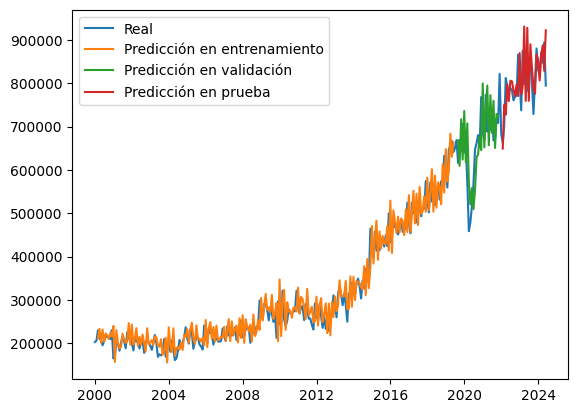

In [139]:
df_train = pd.DataFrame(prediccion_train, columns = ["Predicción en entrenamiento"], index = regular[retrasos:num_separacion-num_val].index)
df_val = pd.DataFrame(prediccion_val, columns = ["Predicción en validación"], index = regular[num_separacion-num_val+retrasos:num_separacion].index)
df_test = pd.DataFrame(prediccion_test, columns = ["Predicción en prueba"], index = regular[num_separacion+retrasos:].index)

plt.plot(regular, label = "Real")
plt.plot(df_train, label = "Predicción en entrenamiento")
plt.plot(df_val, label = "Predicción en validación")
plt.plot(df_test, label = "Predicción en prueba")
plt.legend()
plt.show()

Error del segundo LSTM:

In [140]:
print("RMSE modelo2 (sobre el conjunto de prueba):", root_mean_squared_error(regular[num_separacion+retrasos:], df_test))

RMSE modelo2 (sobre el conjunto de prueba): 64170.08934440426


### Discusión

El primer modelo tenía solo un retraso (el mes anterior) y contó con 50 épocas de entrenamiento. Constaba de 64 neuronas tipo LSTM, una capa de 8 densas y finalmente una única densa para realizar un único output para la predicción. El segundo modelo fue hecho con 2 retrasos (2 meses anteriores como información), una capa adicional de 16 neuronas densas junto con las capas ya mencionadas del modelo 1 y 100 épocas de entrenamiento. Entre estos dos modelos, el mejor modelo fue el primero, con un RMSE de 58824 barriles; mientras que el segundo modelo tenía un RMSE de 64170 barriles.  

Sin embargo, ninguno de los dos modelos pudo exceder la precisión de los modelos ARIMA y Prophet generados en el laboratorio anterior (considerando que se favorece siempre al modelo que tenga un RMSE menor). El modelo ARIMA tenía un RMSE de 57237 barriles y el Prophet, un RMSE de 54465 barriles. Por lo tanto, entre todos los modelos, el mejor para predecir el consumo de gasolina regular por mes es el modelo generado con Prophet. Debe tomarse en cuenta la escala de la cantidad de barriles consumidos por mes, por lo que 50000 barriles de error no es malo; sin embargo, se nota que los modelos no pueden tomar en cuenta la volatilidad del mercado petrolero.

## Importación Diesel

In [219]:
diesel = importacion[['Fecha', 'Diesel']].copy()
diesel.set_index('Fecha', inplace = True)


In [220]:
print("Prueba de Dickey-Fuller para la serie de tiempo de consumo de gasolina regular")
dieselDiFu = adfuller(diesel, autolag = "AIC")
salidaDf = pd.Series(dieselDiFu[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dieselDiFu[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Prueba de Dickey-Fuller para la serie de tiempo de consumo de gasolina regular
Estadístico de prueba         -0.813057
p-value                        0.815257
# de retardos usados          13.000000
# de observaciones usadas    268.000000
Critical Value (1%)           -3.454988
Critical Value (5%)           -2.872386
Critical Value (10%)          -2.572549
dtype: float64


El valor-p de la prueba ADF confirma que no es una serie de tiempo estacionaria en media. Por lo tanto, es necesario diferenciarla.

In [221]:
print("Prueba de Dickey-Fuller para una diferenciación de la serie de tiempo de importación de gasolina regular")
diesel_diff = diesel.diff()
diesel_diff.fillna(0,inplace = True)
dieselDiFu = adfuller(diesel_diff, autolag = "AIC")
salidaDf = pd.Series(dieselDiFu[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dieselDiFu[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Prueba de Dickey-Fuller para una diferenciación de la serie de tiempo de importación de gasolina regular
Estadístico de prueba       -8.990378e+00
p-value                      6.917734e-15
# de retardos usados         1.200000e+01
# de observaciones usadas    2.690000e+02
Critical Value (1%)         -3.454896e+00
Critical Value (5%)         -2.872345e+00
Critical Value (10%)        -2.572528e+00
dtype: float64


El valor-p confirma que con una diferenciación es suficiente para que la serie de tiempo sea estacionaria en media.

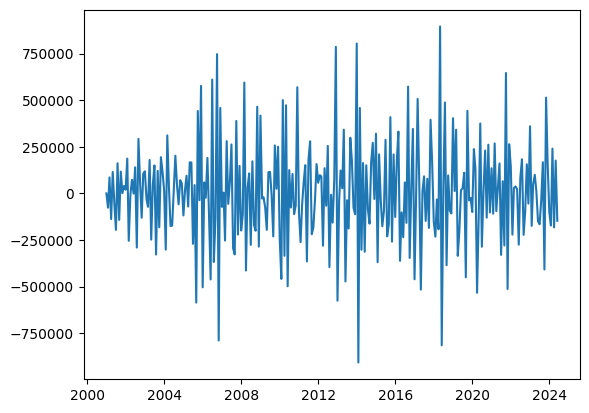

In [222]:
plt.plot(diesel_diff)

In [223]:
scaler = StandardScaler()
diesel_diff_scaled = scaler.fit_transform(diesel_diff)

### Separación entre set de entrenamiento y testeo (igual al laboratorio 2)

In [224]:
train_size = int(len(diesel) * 0.7)
vals_size = int(len(diesel) * 0.8)
train = diesel_diff_scaled[:train_size]
validation = diesel_diff_scaled[train_size:vals_size]
test = diesel_diff_scaled[vals_size:]

In [225]:
def df_a_X_y(df,retrasos = 1):
    if type(df) is pd.DataFrame:
        df_as_np = df.to_numpy()
    else:
        df_as_np = df
    X = []
    y = []
    for i in range(len(df_as_np)-retrasos):
        row = [a for a in df_as_np[i:(i+retrasos)]]
        X.append(row)
        label = df_as_np[i+retrasos][0]
        y.append(label)
        
    return np.array(X), np.array(y)


retrasos = 1
x_train,y_train = df_a_X_y(train, retrasos)
x_val,y_val = df_a_X_y(validation, retrasos)
x_test,y_test = df_a_X_y(test, retrasos)

### Creación primer modelo

In [226]:
modelo1 = Sequential()

modelo1.add(InputLayer((retrasos, 1)))
modelo1.add(LSTM(64))
modelo1.add(Dense(8, 'relu'))
modelo1.add(Dense(1, 'linear'))
modelo1.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_13 (LSTM)                  │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,425 (68.07 KB)

 Trainable params: 17,425 (68.07 KB)

 Non-trainable params: 0 (0.00 B)

In [227]:
modelo1.compile(loss=MeanSquaredError(),optimizer="rmsprop")

In [228]:
epocas = 50
history= modelo1.fit(
    x = x_train,
    y = y_train,
    epochs = epocas,
    shuffle = False,
    validation_data = (x_val, y_val)
)

Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.8154 - val_loss: 1.3792
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7810 - val_loss: 1.3499
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7553 - val_loss: 1.3165
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7286 - val_loss: 1.2879
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7066 - val_loss: 1.2637
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6883 - val_loss: 1.2426
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6725 - val_loss: 1.2239
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6592 - val_loss: 1.2072
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6480 - val_loss: 1.1923
Epoch 10/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6386 - val_loss: 1.1790
Epoch 11/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6308 - val_loss: 1.1670
Epoch 12/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6243 - val_loss: 1.1562
Epoch 13/50


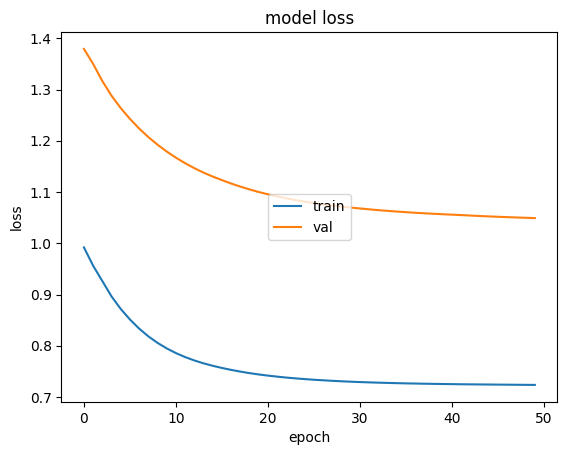

In [229]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='center')

In [230]:
print("Pérdida en Entrenamiento")
modelo1.evaluate(
    x = x_train,
    y = y_train
)
print("Pérdida en Validación")
modelo1.evaluate(
    x = x_val,
    y = y_val
)
print("Pérdida en Prueba")
modelo1.evaluate(
    x = x_test,
    y = y_test
)

Pérdida en Entrenamiento
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 667us/step - loss: 0.5879
Pérdida en Validación
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.0491
Pérdida en Prueba
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5542 


0.5392267107963562

In [231]:
prediccion_train = prediccion_fun(x_train,modelo1, 1,scaler,dif=True,dif_cant=1, Series = diesel.values, n=0, retrasos = retrasos)
prediccion_val = prediccion_fun(x_val,modelo1, 1,scaler,dif=True,dif_cant=1, Series = diesel.values , n=train_size, retrasos = retrasos)
prediccion_test = prediccion_fun(x_test,modelo1, 1,scaler,dif=True,dif_cant=1, Series = diesel.values , n=vals_size, retrasos = retrasos)

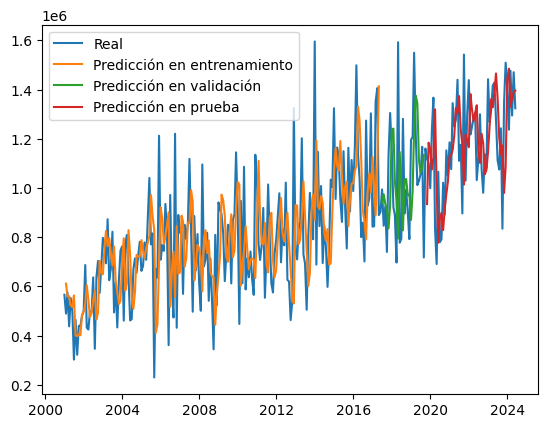

In [232]:
df_train = pd.DataFrame(prediccion_train, columns = ["Predicción en entrenamiento"], index = diesel[1:train_size].index)
df_val = pd.DataFrame(prediccion_val, columns = ["Predicción en validación"], index = diesel[train_size+1:vals_size].index)
df_test = pd.DataFrame(prediccion_test, columns = ["Predicción en prueba"], index = diesel[vals_size+1:].index)

plt.plot(diesel, label = "Real")
plt.plot(df_train, label = "Predicción en entrenamiento")
plt.plot(df_val, label = "Predicción en validación")
plt.plot(df_test, label = "Predicción en prueba")
plt.legend()
plt.show()

Los errores de los modelos generados en el laboratorio 2 son los siguientes:

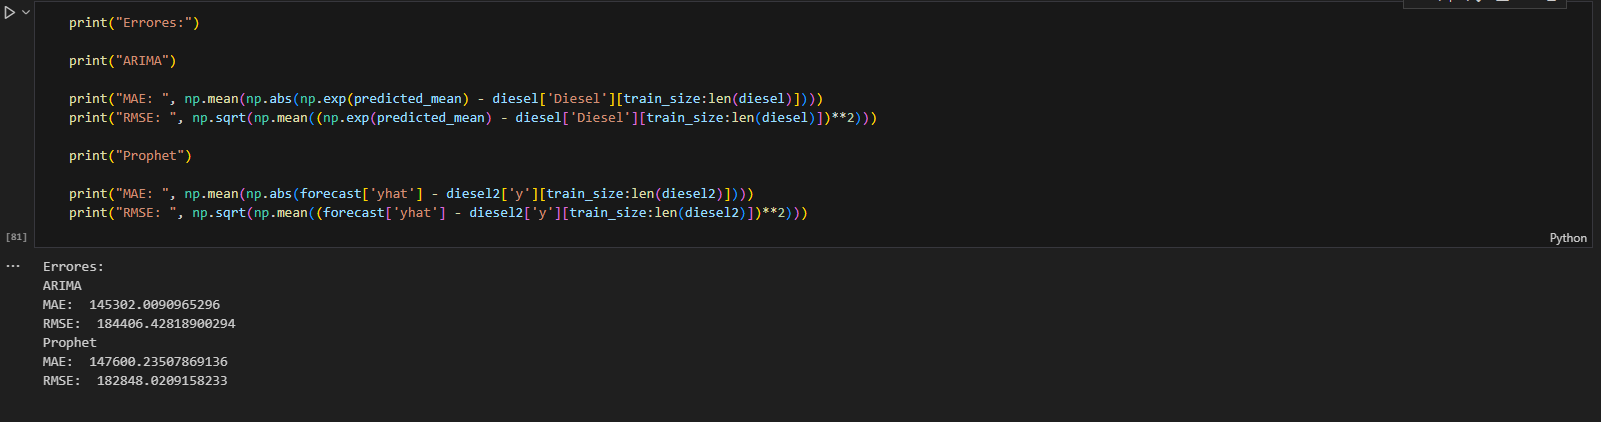

In [233]:
from IPython.display import Image
Image("ErroresDiesel.png")

Error del primer LSTM:

In [234]:
print("RMSE modelo1 (sobre el conjunto de prueba):", root_mean_squared_error(diesel[vals_size+retrasos:], df_test))

RMSE modelo1 (sobre el conjunto de prueba): 200996.62884695397


### Creación segundo modelo

In [235]:

retrasos = 7
x_train,y_train = df_a_X_y(train, retrasos)
x_val,y_val = df_a_X_y(validation, retrasos)
x_test,y_test = df_a_X_y(test, retrasos)

In [236]:
modelo2 = Sequential()


modelo2.add(InputLayer((retrasos, 1)))
modelo2.add(LSTM(64))
modelo2.add(Dense(8, 'relu'))
modelo2.add(Dense(1, 'linear'))
modelo2.summary()

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_14 (LSTM)                  │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,425 (68.07 KB)

 Trainable params: 17,425 (68.07 KB)

 Non-trainable params: 0 (0.00 B)

In [237]:
modelo2.compile(loss=MeanSquaredError(),optimizer="rmsprop")

In [238]:
epocas = 100
history= modelo2.fit(
    x = x_train,
    y = y_train,
    epochs = epocas,
    shuffle = False,
    validation_data = (x_val, y_val)
)

Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.8722 - val_loss: 1.6015
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.8435 - val_loss: 1.5622
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.8248 - val_loss: 1.5253
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.8066 - val_loss: 1.4871
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7829 - val_loss: 1.4351
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7561 - val_loss: 1.3857
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7294 - val_loss: 1.3341
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7013 - val_loss: 1.2812
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6721 - val_loss: 1.2273
Epoch 10/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6421 - val_loss: 1.1735
Epoch 11/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6114 - val_loss: 1.1225
Epoch 12/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5813 - val_loss: 1.0747


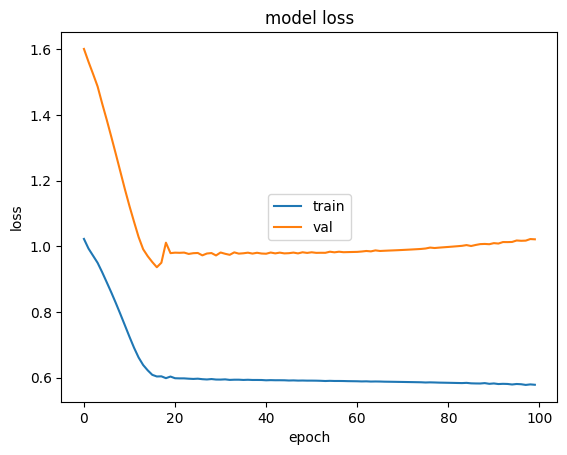

In [239]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='center')

In [240]:
print("Pérdida en Entrenamiento")
modelo2.evaluate(
    x = x_train,
    y = y_train
)
print("Pérdida en Validación")
modelo2.evaluate(
    x = x_val,
    y = y_val
)
print("Pérdida en Prueba")
modelo2.evaluate(
    x = x_test,
    y = y_test
)

Pérdida en Entrenamiento
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step - loss: 0.5049
Pérdida en Validación
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.0214
Pérdida en Prueba
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5196 


0.5205272436141968

In [241]:
prediccion_train = prediccion_fun(x_train,modelo2, 1,scaler,dif=True,dif_cant=1, Series = diesel.values, n=0, retrasos = retrasos)
prediccion_val = prediccion_fun(x_val,modelo2, 1,scaler,dif=True,dif_cant=1, Series = diesel.values , n=train_size, retrasos = retrasos)
prediccion_test = prediccion_fun(x_test,modelo2, 1,scaler,dif=True,dif_cant=1, Series = diesel.values , n=vals_size, retrasos = retrasos)

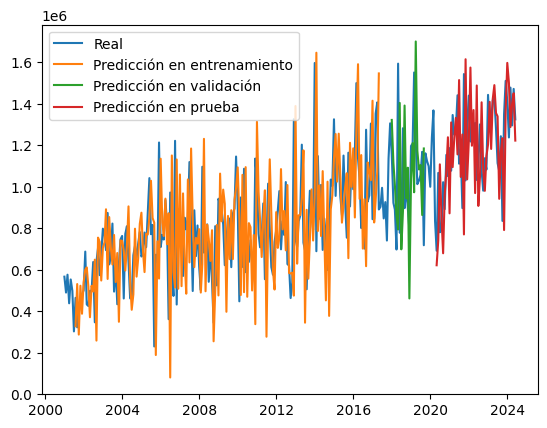

In [242]:
df_train = pd.DataFrame(prediccion_train, columns = ["Predicción en entrenamiento"], index = diesel[retrasos:train_size].index)
df_val = pd.DataFrame(prediccion_val, columns = ["Predicción en validación"], index = diesel[train_size+retrasos:vals_size].index)
df_test = pd.DataFrame(prediccion_test, columns = ["Predicción en prueba"], index = diesel[vals_size+retrasos:].index)

plt.plot(diesel, label = "Real")
plt.plot(df_train, label = "Predicción en entrenamiento")
plt.plot(df_val, label = "Predicción en validación")
plt.plot(df_test, label = "Predicción en prueba")
plt.legend()
plt.show()

Los errores de los modelos generados en el laboratorio 2 son los siguientes:

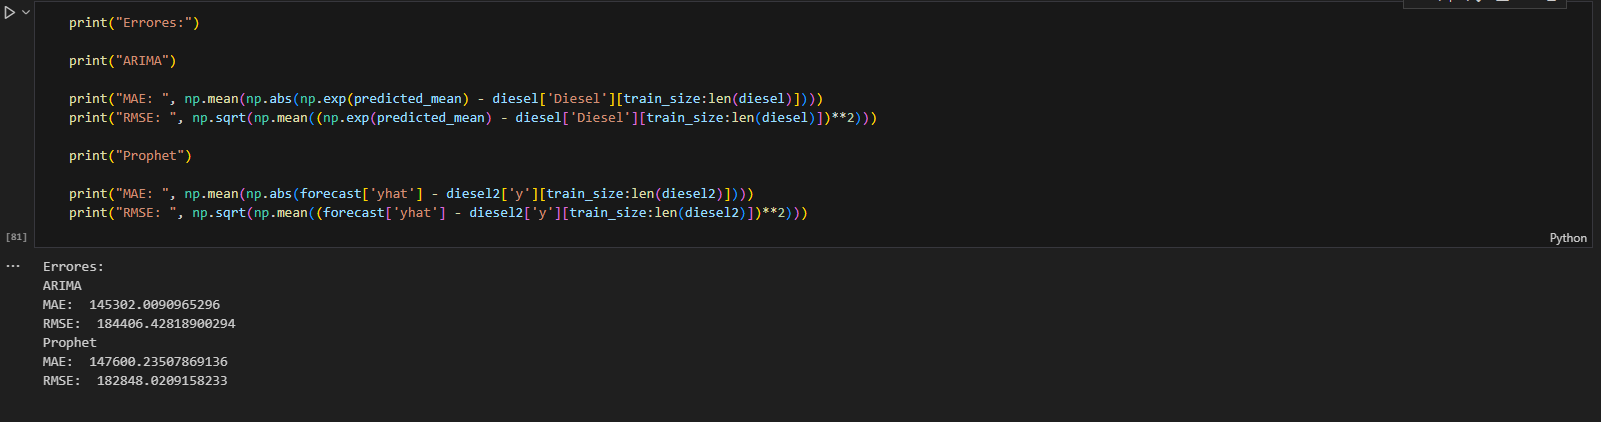

In [243]:
from IPython.display import Image
Image("ErroresDiesel.png")

Error del segundo LSTM:

In [244]:
print("RMSE modelo2 (sobre el conjunto de prueba):", root_mean_squared_error(diesel[vals_size+retrasos:], df_test))

RMSE modelo2 (sobre el conjunto de prueba): 267869.06393233937


### Discusión

El primer modelo sobre la importación de Diesel tenía 1 retraso y contó con 50 épocas de entrenamiento, mientras que el segundo contaba con 7 retrasos y 100 épocas de entrenamiento. Ambos constaban con 64 neuronas LSTM, con una capa de 8 densas y una única densa para realizar la predicción. El primer modelo generó mejores predicciones con un RMSE de 200,137; mientras que el seugndo genero un RMSE de 267,869. Ambos de estos modelos; sin embargo, fueron peores que los modelos generados en el laboratorio 2, un ARIMA y un Prophet. El que mejor se ajustó fue el modelo Prophet, con un RMSE de 182,848.  

Mientras que el RMSE es alto, se debe considerar que la escala de las importaciones es de más de 1,000,000 en promedio, por lo que el error relativo podría no ser tan grande. Sin embargo por los errores se puede asumir que estos datos no se prestan a ser modelados muy cercanamente, probablemente a lo volátil que es el mercado del petróleo y el gas. 

## Precio de Gasolina Superior

In [143]:
superior = precios[["Fecha", "Superior"]].copy()
superior.set_index("Fecha", inplace = True)
superior.head()


,Superior
Fecha,
2021-01-01,21.91
2021-01-02,21.91
2021-01-03,21.91
2021-01-04,21.91
2021-01-05,21.91


In [144]:
print("Prueba de Dickey-Fuller para la serie de tiempo del precio de gasolina superior")
superiorTest = adfuller(superior, autolag = "AIC")
salidaDf = pd.Series(superiorTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in superiorTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Prueba de Dickey-Fuller para la serie de tiempo del precio de gasolina superior
Estadístico de prueba          -2.963637
p-value                         0.038433
# de retardos usados            7.000000
# de observaciones usadas    1318.000000
Critical Value (1%)            -3.435321
Critical Value (5%)            -2.863735
Critical Value (10%)           -2.567939
dtype: float64


El valor-p de la prueba ADF confirma que es una serie de tiempo estacionaria en media. Por lo tanto, no es necesario diferenciarla.

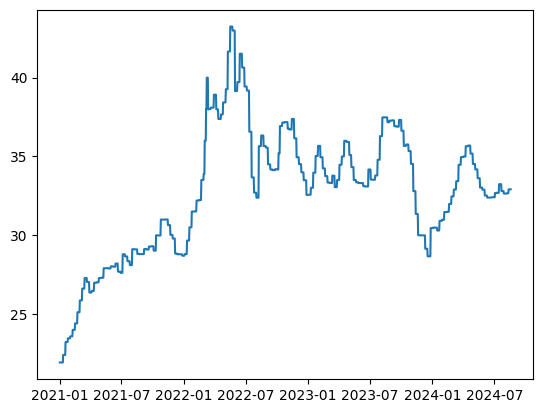

In [145]:
plt.plot(superior)

In [146]:
scaler3 = StandardScaler()
superior_scaled = scaler3.fit_transform(superior)

### Separación entre set de entrenamiento y testeo (igual al laboratorio 2)

In [147]:
num_separacion = precios.index[precios["Fecha"]==pd.to_datetime("2023-12-31")][0]
num_val = int(len(superior_scaled)*0.1)
train = superior_scaled[:num_separacion-num_val]
validation = superior_scaled[num_separacion-num_val:num_separacion]
test = superior_scaled[num_separacion:]

In [148]:
retrasos = 1
x_train,y_train = df_a_X_y(train, retrasos)
x_val,y_val = df_a_X_y(validation, retrasos)
x_test,y_test = df_a_X_y(test, retrasos)

### Creación primer modelo

In [152]:
modelo1 = Sequential()

modelo1.add(InputLayer((retrasos, 1)))
modelo1.add(LSTM(64))
modelo1.add(Dense(8, 'relu'))
modelo1.add(Dense(1, 'linear'))
modelo1.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_11 (LSTM)                  │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,425 (68.07 KB)

 Trainable params: 17,425 (68.07 KB)

 Non-trainable params: 0 (0.00 B)

In [153]:
modelo1.compile(loss=MeanSquaredError(),optimizer="rmsprop")

In [154]:
epocas = 50
history= modelo1.fit(
    x = x_train,
    y = y_train,
    epochs = epocas,
    shuffle = False,
    validation_data = (x_val, y_val)
)

Epoch 1/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.1003 - val_loss: 0.5156
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.8773 - val_loss: 0.3910
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7190 - val_loss: 0.2894
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.5676 - val_loss: 0.2083
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.4157 - val_loss: 0.1505
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2608 - val_loss: 0.1092
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1075 - val_loss: 0.0799
Epoch 8/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9544 - val_loss: 0.0570
Epoch 9/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8097 - val_loss: 0.0393
Epoch 10/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6769 - val_loss: 0.0263
Epoch 11/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5589 - val_loss: 0.0173
Epoch 12/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4549 - val_lo

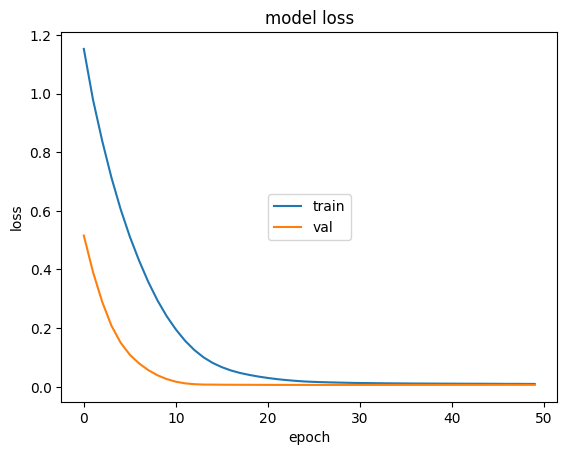

In [155]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='center')

In [156]:
print("Pérdida en Entrenamiento")
modelo1.evaluate(
    x = x_train,
    y = y_train
)
print("Pérdida en Validación")
modelo1.evaluate(
    x = x_val,
    y = y_val
)
print("Pérdida en Prueba")
modelo1.evaluate(
    x = x_test,
    y = y_test
)

Pérdida en Entrenamiento
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 901us/step - loss: 0.0082
Pérdida en Validación
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 65us/step - loss: 0.0048    
Pérdida en Prueba
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0015     


0.00151855091098696

In [157]:
prediccion_train = prediccion_fun(x_train,modelo1, 1,scaler3,dif=False)
prediccion_val = prediccion_fun(x_val,modelo1, 1,scaler3,dif=False)
prediccion_test = prediccion_fun(x_test,modelo1, 1,scaler3,dif=False)

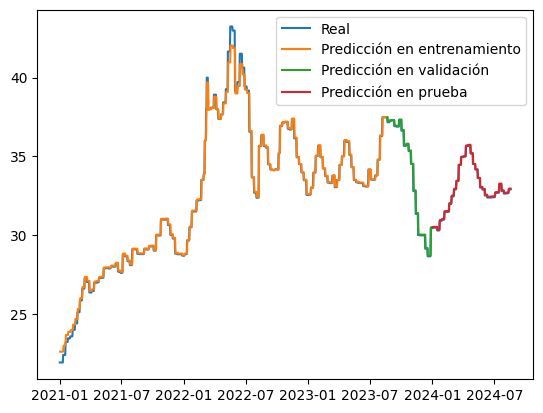

In [158]:
df_train = pd.DataFrame(prediccion_train, columns = ["Predicción en entrenamiento"], index = superior[retrasos:num_separacion-num_val].index)
df_val = pd.DataFrame(prediccion_val, columns = ["Predicción en validación"], index = superior[num_separacion-num_val+retrasos:num_separacion].index)
df_test = pd.DataFrame(prediccion_test, columns = ["Predicción en prueba"], index = superior[num_separacion+retrasos:].index)

plt.plot(superior, label = "Real")
plt.plot(df_train, label = "Predicción en entrenamiento")
plt.plot(df_val, label = "Predicción en validación")
plt.plot(df_test, label = "Predicción en prueba")
plt.legend()
plt.show()

Los errores de los modelos generados en el laboratorio 2 son los siguientes:

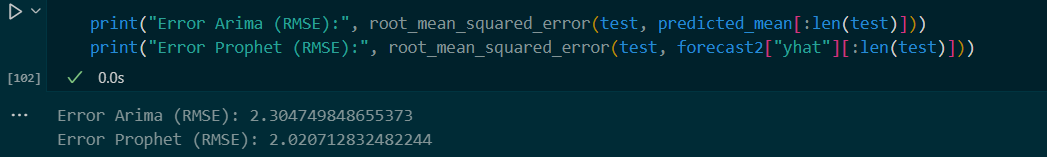

In [258]:
Image("ErroresSuperior.png")

Error del primer LSTM:

In [159]:
print("RMSE modelo1 (sobre el conjunto de prueba):", root_mean_squared_error(superior[num_separacion+retrasos:], df_test))

RMSE modelo1 (sobre el conjunto de prueba): 0.1591016253378711


### Creación segundo modelo

In [160]:
retrasos = 7
x_train,y_train = df_a_X_y(train, retrasos)
x_val,y_val = df_a_X_y(validation, retrasos)
x_test,y_test = df_a_X_y(test, retrasos)

modelo2 = Sequential()

modelo2.add(InputLayer((retrasos, 1)))
modelo2.add(LSTM(64))
modelo2.add(Dense(8, 'relu'))
modelo2.add(Dense(1, 'linear'))
modelo2.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_12 (LSTM)                  │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,425 (68.07 KB)

 Trainable params: 17,425 (68.07 KB)

 Non-trainable params: 0 (0.00 B)

In [161]:
modelo2.compile(loss=MeanSquaredError(),optimizer="rmsprop")

In [163]:
epocas = 100
history= modelo2.fit(
    x = x_train,
    y = y_train,
    epochs = epocas,
    shuffle = False,
    validation_data = (x_val, y_val)
)

Epoch 1/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 1.6599 - val_loss: 0.1567
Epoch 2/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0275 - val_loss: 0.0607
Epoch 3/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5142 - val_loss: 0.0244
Epoch 4/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2694 - val_loss: 0.0223
Epoch 5/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1991 - val_loss: 0.0226
Epoch 6/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1553 - val_loss: 0.0228
Epoch 7/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1210 - val_loss: 0.0231
Epoch 8/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0965 - val_loss: 0.0231
Epoch 9/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0781 - val_loss: 0.0233
Epoch 10/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0645 - val_loss: 0.0235
Epoch 11/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0554 - val_loss: 0.0232
Epoch 12/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.

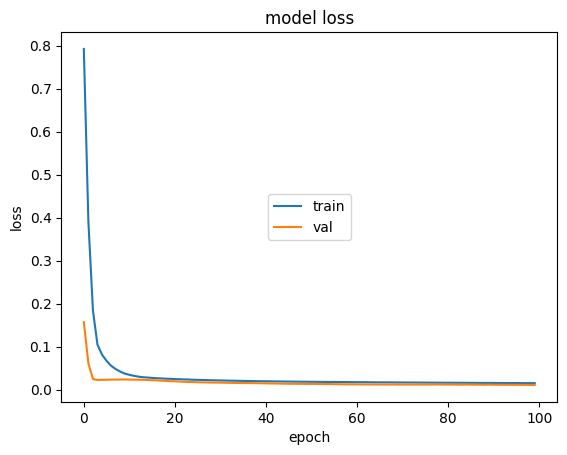

In [164]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='center')

In [165]:
print("Pérdida en Entrenamiento")
modelo2.evaluate(
    x = x_train,
    y = y_train
)
print("Pérdida en Validación")
modelo2.evaluate(
    x = x_val,
    y = y_val
)
print("Pérdida en Prueba")
modelo2.evaluate(
    x = x_test,
    y = y_test
)

Pérdida en Entrenamiento
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0115 
Pérdida en Validación
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0068     
Pérdida en Prueba
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0032 


0.003095772350206971

In [166]:
prediccion_train = prediccion_fun(x_train,modelo2, 1,scaler3,dif=False)
prediccion_val = prediccion_fun(x_val,modelo2, 1,scaler3,dif=False)
prediccion_test = prediccion_fun(x_test,modelo2, 1,scaler3,dif=False)

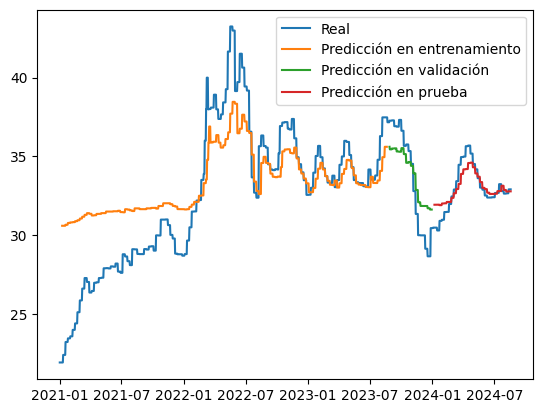

In [167]:
df_train = pd.DataFrame(prediccion_train, columns = ["Predicción en entrenamiento"], index = superior[retrasos:num_separacion-num_val].index)
df_val = pd.DataFrame(prediccion_val, columns = ["Predicción en validación"], index = superior[num_separacion-num_val+retrasos:num_separacion].index)
df_test = pd.DataFrame(prediccion_test, columns = ["Predicción en prueba"], index = superior[num_separacion+retrasos:].index)

plt.plot(superior, label = "Real")
plt.plot(df_train, label = "Predicción en entrenamiento")
plt.plot(df_val, label = "Predicción en validación")
plt.plot(df_test, label = "Predicción en prueba")
plt.legend()
plt.show()

Error del segundo LSTM:

In [168]:
print("RMSE modelo2 (sobre el conjunto de prueba):", root_mean_squared_error(superior[num_separacion+retrasos:], df_test))

RMSE modelo2 (sobre el conjunto de prueba): 0.7091144932065077


### Discusión

El primer modelo tenía solo un retraso (el día anterior) y contó con 50 épocas de entrenamiento. Constaba de 64 neuronas tipo LSTM, una capa de 8 densas y finalmente una única densa para realizar un único output para la predicción. El segundo modelo fue hecho con 7 retrasos (es decir, los precios de una semana anterior como información), las mismas redes neuronales del primer modelo y 100 épocas de entrenamiento. Entre estos dos modelos, el mejor modelo fue el primero, con un RMSE de 0.16 quetzales por galón; mientras que el segundo modelo tenía un RMSE de Q0.71 por galón.  

Los modelos LSTM demostraron ser mejores para predecir el precio diario de la gasolina superior que los modelos generados en el laboratorio anterior. El modelo ARIMA tenía un RMSE de Q2.30 por galón y el modelo Prophet tenía uno de Q2.02 por galón. Es una gran mejora, considerando que los modelos LSTM en promedio se alejan del precio real por centavos, en vez de quetzales completos.